In [1]:
# !python script.py

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
# from torchvision import models
from torchsummary import summary
import PIL
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import pandas as pd
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix


from pathlib import Path
from collections import defaultdict
from tqdm.notebook import tqdm
import validators

import argparse
import re
from collections import Counter

import logging


In [3]:

print("number_of_cpus: ", torch.get_num_threads())
torch.set_num_threads(8)
print("confined to number_of_cpus: ", torch.get_num_threads())

number_of_cpus:  6
confined to number_of_cpus:  16


In [4]:
## using argparse to set parameters
parser = argparse.ArgumentParser(description='Train model on UCB Image Dataset')
parser.add_argument('--source_dataset_dir', type=str, default='/projectnb/cs640grp/materials/UBC-OCEAN_CS640', help='path to dataset')
parser.add_argument('--local_dataset_dir', type=str, default='../../../dataset', help='path to local dataset')
parser.add_argument('--model_dir', type=str, default='./model', help='path to tained model')
parser.add_argument('--experiment_name', type=str, default='exp_1', help='experiment name')

parser.add_argument('--train_image_folder', type=str, default='img_size_512x512', help='training image folder name')
parser.add_argument('--eval_image_folder', type=str, default='test_img_size_512x512', help='evaluate image folder name')
# parser.add_argument('--train_image_folder', type=str, default='train_images_compressed_80', help='training image folder name')
parser.add_argument('--image_input_size', type=str, default='(512, 512)', help='input image size')
parser.add_argument('--batch_size', type=int, default=8, help='batch size')
parser.add_argument('--num_epochs', type=int, default=10, help='number of epochs')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
# parser.add_argument('--momentum', type=float, default=0.9, help='momentum')
parser.add_argument('--weight_decay', type=float, default=0.0001, help='weight decay')
parser.add_argument('--eval_patience', type=int, default=20, help='patience for early stopping')

_StoreAction(option_strings=['--eval_patience'], dest='eval_patience', nargs=None, const=None, default=20, type=<class 'int'>, choices=None, required=False, help='patience for early stopping', metavar=None)

In [5]:
settings = None
try:
    __IPYTHON__
    _in_ipython_session = True
    settings = parser.parse_args("")
except NameError:
    _in_ipython_session = False
    settings = parser.parse_args()

print("settings:", vars(settings))
# # save settings in to a log file
# with open(Path(settings.model_dir, settings.experiment_name, 'settings.txt'), 'w') as f:
#     print(vars(settings), file=f)

settings: {'source_dataset_dir': '/projectnb/cs640grp/materials/UBC-OCEAN_CS640', 'local_dataset_dir': '../../../dataset', 'model_dir': './model', 'experiment_name': 'exp_1', 'train_image_folder': 'img_size_512x512', 'eval_image_folder': 'test_img_size_512x512', 'image_input_size': '(512, 512)', 'batch_size': 8, 'num_epochs': 10, 'lr': 0.001, 'weight_decay': 0.0001, 'eval_patience': 20}


In [6]:
image_input_size = eval(settings.image_input_size)
assert isinstance(image_input_size, tuple) and len(image_input_size) == 2, "image_input_size must be a tuple of length 2"

# # vars(settings)
# # print(image_input_size)

In [7]:
PIL.Image.MAX_IMAGE_PIXELS = 933120000
# IMAGE_INPUT_SIZE = (2048, 2048)

IMAGE_INPUT_SIZE = image_input_size

In [8]:
def create_dir_if_not_exist(dir):
    # if not os.path.exists(dir):
    #     os.makedirs(dir)
    if not Path(dir).exists():
        Path(dir).mkdir(parents=True, exist_ok=True)

In [9]:
SOURCE_DATASET_DIR = settings.source_dataset_dir
# DATASET_PATH = "dataset"
# TRAIN_IMAGE_FOLDER = "train_images_compressed_80"
# TEST_IMAGE_FOLDER = "test_images_compressed_80"
# TRAIN_IMAGE_FOLDER = f"img_size_{IMAGE_INPUT_SIZE[0]}x{IMAGE_INPUT_SIZE[1]}"
TRAIN_IMAGE_FOLDER = settings.train_image_folder
EVAL_IMAGE_FOLDER = settings.eval_image_folder


# LOCAL_DATASET_DIR = "./dataset"
# MODEL_DIR = "./model/"
# EXPERIMENT_NAME = "exp_1"

LOCAL_DATASET_DIR = settings.local_dataset_dir
MODEL_DIR = settings.model_dir
EXPERIMENT_NAME = settings.experiment_name

sub_folder_name = f"img_size_{IMAGE_INPUT_SIZE[0]}x{IMAGE_INPUT_SIZE[1]}_lr_{settings.lr}__batch_size_{settings.batch_size}__num_epochs_{settings.num_epochs}__weight_decay_{settings.weight_decay}__eval_patience_{settings.eval_patience}"
sub_folder_name = re.sub(r"\.", "p", sub_folder_name)
MODEL_SAVE_DIR = Path(MODEL_DIR, EXPERIMENT_NAME, sub_folder_name)
RESULT_DIR = Path("./result", EXPERIMENT_NAME, sub_folder_name)
print("RESULT_DIR:", RESULT_DIR)

LOG_DIR = Path("./log", EXPERIMENT_NAME)
print("LOG_DIR:", LOG_DIR)
create_dir_if_not_exist(LOG_DIR)


RESULT_DIR: result\exp_1\img_size_512x512_lr_0p001__batch_size_8__num_epochs_10__weight_decay_0p0001__eval_patience_20
LOG_DIR: log\exp_1


In [10]:
# # logging.basicConfig(level=logging.DEBUG)



# logging.basicConfig(level=logging.INFO, filename='log.txt', filemode='w',
logging.basicConfig(level=logging.DEBUG, filename=LOG_DIR/'log.txt', filemode='w',
	format='[%(asctime)s %(levelname)-8s] %(message)s',
	datefmt='%Y%m%d %H:%M:%S',
	)

# if __name__ == "__main__":
# 	logging.debug('debug')
# 	logging.info('info')
# 	logging.warning('warning')
# 	logging.error('error')
# 	logging.critical('critical')
# 	time.sleep(5)


In [11]:
# lr = 0.001
# # momentum = 0.9
# weight_decay = 0.0001
# num_epochs = 20
# batch_size = 32

eval_patience = settings.eval_patience
lr = settings.lr
# momentum = settings.momentum
weight_decay = settings.weight_decay
num_epochs = settings.num_epochs
batch_size = settings.batch_size

In [12]:
create_dir_if_not_exist(LOCAL_DATASET_DIR)

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [14]:
#pandas load data from csv
train_csv = None
test_csv = None
all_labels = None

if os.path.exists(Path(LOCAL_DATASET_DIR) / 'train.csv'):
    train_csv = pd.read_csv(Path(LOCAL_DATASET_DIR) / 'train.csv').to_numpy()
else:
    train_csv = pd.read_csv(Path(SOURCE_DATASET_DIR) / 'train.csv').to_numpy()

if os.path.exists(Path(LOCAL_DATASET_DIR) / 'test.csv'):
    test_csv = pd.read_csv(Path(LOCAL_DATASET_DIR) / 'test.csv').to_numpy()
else:
    test_csv = pd.read_csv(Path(SOURCE_DATASET_DIR) / 'test.csv').to_numpy()

# load npy
if os.path.exists(Path(LOCAL_DATASET_DIR) / 'all_labels.npy'):
    all_labels = np.load(Path(LOCAL_DATASET_DIR) / 'all_labels.npy')
else:
    all_labels = np.load(Path(SOURCE_DATASET_DIR) / 'all_labels.npy')




In [15]:
dict_id_to_label = {i: label for i, label in enumerate(all_labels)}
dict_label_to_id = {label: i for i, label in enumerate(all_labels)}


print("dict_id_to_label:", sorted(dict_id_to_label.items()))

dict_id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]


In [16]:
def tran_csv_to_img_path_and_label(x_csv, data_path, image_folder, dict_label_to_id):
    x_data = []
    for i in range(len(x_csv)):
        #get img path
        img_name = str(x_csv[i][0]) + ".jpg"
        img_path = Path(data_path)  / image_folder / img_name
        # check image is exist
        if not img_path.exists():
            print(f"image {img_path} does not exist")
            continue

        x_data.append([img_path, dict_label_to_id[x_csv[i][1]]])
    return x_data

In [17]:
train_image_path_and_label = tran_csv_to_img_path_and_label(train_csv, LOCAL_DATASET_DIR, TRAIN_IMAGE_FOLDER, dict_label_to_id)
test_image_path_and_label = tran_csv_to_img_path_and_label(test_csv, LOCAL_DATASET_DIR, EVAL_IMAGE_FOLDER, dict_label_to_id)

# # Random split
# # train_set, valid_set = train_test_split(train_image_path_and_label, test_size=0.2, random_state=42)
# train_set, valid_set = train_test_split(train_image_path_and_label, test_size=0.2, random_state=42, 
#                                         stratify=[x[1] for x in train_image_path_and_label])
train_set = train_image_path_and_label
valid_set = test_image_path_and_label

if EXPERIMENT_NAME == "efficientnet_b0__train_on_all_data":
    train_set = train_image_path_and_label + test_image_path_and_label

print("train set size:", len(train_set))    
print("valid set size:", len(valid_set))
# print("test set size:", len(test_set))

path_list, labels = zip(*train_set)
print("train set category distribution: \n\t", Counter(labels))

path_list, labels = zip(*valid_set)
print("train set category distribution: \n\t", Counter(labels))

train set size: 430
valid set size: 108
train set category distribution: 
	 Counter({0: 177, 1: 99, 3: 79, 4: 38, 2: 37})
train set category distribution: 
	 Counter({0: 45, 1: 25, 3: 20, 2: 9, 4: 9})


In [18]:
def show_img_by_path(img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print(img.size, type(img))
    img = transforms.Resize(IMAGE_INPUT_SIZE)(img)
    print(img.size, type(img))
    img = transforms.ToTensor()(img)
    print(img.shape)
    # print(img)
    
# show_img_by_path(train_set[0][0])

In [19]:
from torchvision.io import read_image

class UBCDataset(Dataset):
    def __init__(self, img_path_and_label, transform=None, target_transform=None, random_add_single_value=False):
        self.data = img_path_and_label
        self.transform = transform
        self.target_transform = target_transform
        self.random_add_single_value = random_add_single_value

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # image = read_image(img_path)
        image_path, label = self.data[idx]
        image = Image.open(image_path)
        # print(np.max(image), np.min(image))

        # image_np = np.array(image)
        # ### white to black
        # mask = (image_np >= np.array([230, 230, 230])).all(axis=-1)
        # image_np[mask] = [0, 0, 0]
        # image = Image.fromarray(image_np)

        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        # print(torch.max(image), torch.min(image))
        
        # if self.random_add_single_value:
        #     image += torch.randn(1) * 0.01
        return image1, label, image2


In [20]:
# put data into dataloader
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_INPUT_SIZE, antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(180),
    # transforms.RandomAffine(180, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10, interpolation=PIL.Image.BILINEAR),
    transforms.RandomAffine(30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10, interpolation=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# v2.Compose([v2.Resize(256, antialias = True),
#                               v2.CenterCrop(224),
#                               v2.ToImage(),
#                               v2.ToDtype(torch.float32, scale = True),
#                               v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])


test_transform = transforms.Compose([
    transforms.Resize(IMAGE_INPUT_SIZE, antialias=True),
    transforms.CenterCrop(IMAGE_INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

train_dataset = UBCDataset(train_set, transform=train_transform, random_add_single_value=True)
valid_dataset = UBCDataset(valid_set, transform=test_transform)
# test_dataset = UBCDataset(test_set, transform=test_transform)



C:\Users\benve\AppData\Local\Temp\ipykernel_14792\1295177147.py:8: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  transforms.RandomAffine(30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10, interpolation=PIL.Image.BILINEAR),


In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [22]:
#show image grid
def show_image_grid(dataloader, num_of_images=16):
    imgs, labels, imgs2 = next(iter(dataloader))

    # imgs_tmp = imgs.permute(0, 2, 3, 1)
    # # mask = (imgs_tmp == torch.tensor([255, 255, 255])).all(dim=3, keepdim=True)
    # mask = (imgs_tmp >= torch.tensor([100, 100, 100])).all(dim=3)
    # imgs_tmp[mask] = torch.tensor([0, 0, 0]).float()
    # imgs = imgs_tmp.permute(0, 3, 1, 2)

    image_grid = torchvision.utils.make_grid(imgs[:num_of_images], nrow=8)
    plt.imshow(image_grid.permute(1, 2, 0).numpy())
    # plt.show()
    print("labels:", labels[:num_of_images], [dict_id_to_label[label.item()] for label in labels[:num_of_images]])

# # show_image_grid(train_dataloader)
# # show_image_grid( DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0), 64)
# show_image_grid( DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0), 64)

In [23]:
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_v2_l', pretrained=True)
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b4', pretrained=True)

# print(dir(efficientnet.modules))
# print(efficientnet.classifier.fc.in_features)

In [24]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

if EXPERIMENT_NAME == "efficientnet_b0":
    efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
elif EXPERIMENT_NAME == "efficientnet_b4":
    efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
elif EXPERIMENT_NAME == "efficientnet_widese_b0":
    efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)
elif EXPERIMENT_NAME == "efficientnet_widese_b4":
    efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b4', pretrained=True)
# elif EXPERIMENT_NAME == "efficientnet_v2_l":
#     efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_v2_l', pretrained=True)

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

# efficientnet.eval().to(device)
# vars(efficientnet)


Using cache found in C:\Users\benve/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\benve/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\benve/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in C:\Users\benve/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


In [25]:
class EfficientNetWrapperModel(nn.Module):
    def __init__(self, efficientnet):
        super(EfficientNetWrapperModel, self).__init__()

        # self.cnn_input_combine = torch.nn.Sequential(
        #             torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
        #             torch.nn.ReLU(),
        #             torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
        #             torch.nn.ReLU(),
        #             torch.nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=1, bias=True),
        #             torch.nn.ReLU()
        #         )

        self.efficientnet = copy.deepcopy(efficientnet)
        self.classifier_in_feature_size = self.efficientnet.classifier.fc.in_features
        
        self.bridge = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d(output_size=1),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=self.classifier_in_feature_size, out_features=256, bias=True),
        )

        self.classifier_head = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2, inplace=False),
            torch.nn.Linear(in_features=256, out_features=128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2, inplace=False),
            torch.nn.Linear(in_features=128, out_features=5, bias=True),
            # torch.nn.Linear(in_features=256, out_features=16, bias=True),
        )
        self.efficientnet.classifier = self.bridge


        # self.combined_classifier_head = torch.nn.Sequential(
        #     torch.nn.Linear(in_features=16*4, out_features=32, bias=True),
        #     torch.nn.ReLU(),
        #     torch.nn.Dropout(p=0.2, inplace=False),
        #     torch.nn.Linear(in_features=32, out_features=5, bias=True),
        # )

        self.transform_downsampler = transforms.Resize((512, 512), antialias=True)

        # self.cnn_input_combine_params = []
        # for name, params in self.cnn_input_combine.named_parameters():
        #     self.cnn_input_combine_params.append(params)

        self.feature_extractor_params = []
        for name, params in self.efficientnet.named_parameters():
            if(name[:10] == "classifier"):
                continue
            self.feature_extractor_params.append(params)

        self.bridge_params = []
        for name, params in self.bridge.named_parameters():
            self.bridge_params.append(params)

        self.classifier_head_params = []
        for name, params in self.classifier_head.named_parameters():
            self.classifier_head_params.append(params)

        # self.combined_classifier_head_params = []
        # for name, params in self.combined_classifier_head.named_parameters():
        #     self.combined_classifier_head_params.append(params)

    def forward(self, imgs):
        # imgs_downsampled = self.transform_downsampler(imgs)
        # concat_in = torch.concat([imgs, imgs_10, imgs_11, imgs_12], dim=1)
        # combine_in = self.cnn_input_combine(concat_in)
        f = self.efficientnet(imgs)
        outputs = self.classifier_head(f)
        # f_orig = self.efficientnet(imgs)
        # f_10 = self.efficientnet(imgs_10)
        # f_11 = self.efficientnet(imgs_11)
        # f_12 = self.efficientnet(imgs_12)
        # comb_f = torch.concat([f_orig, f_10, f_11, f_12], dim=1)
        # print(comb_f.shape)
        # outputs = self.combined_classifier_head(comb_f)
        
        
        return outputs, f
            


In [26]:
# model_raw = efficientnet
# classifier_in_feature_size = model_raw.classifier.fc.in_features
# classifier_head = torch.nn.Sequential(
#     torch.nn.AdaptiveAvgPool2d(output_size=1),
#     torch.nn.Flatten(),
#     torch.nn.Dropout(p=0.2, inplace=False),
#     torch.nn.Linear(in_features=classifier_in_feature_size, out_features=256, bias=True),
#     torch.nn.ReLU(),
#     torch.nn.Dropout(p=0.2, inplace=False),
#     torch.nn.Linear(in_features=256, out_features=5, bias=True),
# )
# model_raw.classifier = classifier_head
# model_raw = model_raw.to(device)


# feature_extractor_params = []
# for name, params in model_raw.named_parameters():
#     if(name[:10] == "classifier"):
#         continue
#     feature_extractor_params.append(params)

# classifier_head_params = []
# for name, params in classifier_head.named_parameters():
#     classifier_head_params.append(params)



    
model_raw = EfficientNetWrapperModel(efficientnet)
model_raw = model_raw.to(device)
# cnn_input_combine_params = model_raw.cnn_input_combine_params
feature_extractor_params = model_raw.feature_extractor_params
bridge_params = model_raw.bridge_params
classifier_head_params = model_raw.classifier_head_params


In [27]:
# print("feature_extractor_params:", len(feature_extractor_params))
# print(classifier_head_params)

In [28]:
summary(model_raw, (3, ) + IMAGE_INPUT_SIZE, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              SiLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              SiLU-6         [-1, 32, 256, 256]               0
            Linear-7                    [-1, 8]             264
              SiLU-8                    [-1, 8]               0
            Linear-9                   [-1, 32]             288
          Sigmoid-10                   [-1, 32]               0
SequentialSqueezeAndExcitation-11         [-1, 32, 256, 256]               0
           Conv2d-12         [-1, 16, 256, 256]             512
      BatchNorm2d-13         [-1, 16, 256, 256]              32
      MBConvBlock-14      

In [29]:

criteria = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model_raw.classifier.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = optim.Adam([{"params":feature_extractor_params, "lr":1e-7}, 
                        {"params":bridge_params, "lr":lr}, 
                        {"params":classifier_head_params, "lr":lr}
                        ], 
                       lr=lr, weight_decay=weight_decay)



In [30]:


def get_category_accuracy(y_gt: np.array, y_pred: np.array, n_category):
    # category_accuracy = np.zeros(n_category)

    assert(len(y_gt) == len(y_pred))
    assert(len(y_gt.shape) == 1 and len(y_pred.shape) == 1)

    cat_mask_2d = (y_gt == np.arange(n_category).reshape(-1, 1))
    category_accuracy = ((y_gt == y_pred) * cat_mask_2d).sum(axis=1) / cat_mask_2d.sum(axis=1)

    return category_accuracy

# a = np.random.randint(0, 5, 10)
# b = np.random.randint(0, 5, 10)
# print("a:", a)
# print("b:", b)

# # print("get_category_accuracy:", get_category_accuracy(y_gt=a, y_pred=b, n_category=5))
# category_accuracy = get_category_accuracy(y_gt=np.array(a), y_pred=np.array(b), n_category=5)
# print("category_accuracy:", category_accuracy)
# print(str(category_accuracy))
# print(type(category_accuracy[0]))
# confusion_matrix_result = confusion_matrix(y_true=a, y_pred=b, labels=[0, 1, 2, 3, 4])
# print("get_category_accuracy:" + str(category_accuracy))


In [31]:
def evaluation(model, valid_dataloader, criteria, device):
        model.eval()
        valid_loss = 0.0
        valid_corrects = 0

        y_gt = []
        y_pred = []

        for imgs, labels, imgs2 in tqdm(valid_dataloader):
            imgs = imgs.to(device)
            imgs2 = imgs2.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs, f = model(imgs)
                outputs2, f2 = model(imgs2)
                
                similarity_scores_a00 = torch.matmul(f, f2.T)

                gt_similarity = torch.eye(similarity_scores_a00.shape[0], device=similarity_scores_a00.device)
                loss_similarity = criteria(similarity_scores_a00, gt_similarity) # cross entropy loss

                _, preds = torch.max(outputs, -1)
                loss_classification = criteria(outputs, labels)
                loss_classification2 = criteria(outputs2, labels)

                loss = loss_similarity + loss_classification + loss_classification2

            valid_loss += loss.item() * imgs.size(0)
            valid_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()

            y_gt.extend(labels.data.cpu().numpy().reshape(-1))
            y_pred.extend(preds.cpu().numpy().reshape(-1))

        # print(y_gt)
        # print(y_pred)
        confusion_matrix_result = confusion_matrix(y_gt, y_pred)
        print("confusion_matrix_result:\n" + str(confusion_matrix_result))
        logging.info("confusion_matrix_result:\n" + str(confusion_matrix_result))

        category_accuracy = get_category_accuracy(y_gt=np.array(y_gt), y_pred=np.array(y_pred), n_category=5)
        print("get_category_accuracy:" + str(category_accuracy))
        logging.info("get_category_accuracy:" + str(category_accuracy))
        
        valid_loss = valid_loss / len(valid_dataloader.dataset)
        valid_acc = valid_corrects / len(valid_dataloader.dataset)

        valid_balanced_acc = balanced_accuracy_score(y_gt, y_pred)

        return valid_loss, valid_acc, valid_balanced_acc, y_pred, y_gt

In [32]:
def train(model, train_dataloader, valid_dataloader, optimizer, criteria, num_epochs, eval_patience, device):
    train_loss_list = []
    train_acc_list = []
    train_balanced_acc_list = []

    valid_loss_list = []
    valid_acc_list = []
    valid_balanced_acc_list = []

    best_valid_loss = float('inf')
    best_valid_acc = -0.0001
    best_valid_balanced_acc = -0.0001

    best_model_valid_loss = None
    best_model_valid_acc = None
    best_model_valid_balanced_acc = None

    start_time = time.time()

    counter_eval_not_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        logging.info(f'Epoch {epoch + 1}/{num_epochs}')
        logging.info('-' * 10)

        model.train()
        train_loss = 0.0
        train_corrects = 0
        
        y_gt = []
        y_pred = []

        for imgs, labels, imgs2 in tqdm(train_dataloader):
            imgs = imgs.to(device)
            imgs2 = imgs2.to(device)
            labels = labels.to(device)

            outputs, f = model(imgs)
            outputs2, f2 = model(imgs2)
            
            similarity_scores_a00 = torch.matmul(f, f2.T)

            gt_similarity = torch.eye(similarity_scores_a00.shape[0], device=similarity_scores_a00.device)
            loss_similarity = criteria(similarity_scores_a00, gt_similarity) # cross entropy loss

            _, preds = torch.max(outputs, -1)
            loss_classification = criteria(outputs, labels)
            loss_classification2 = criteria(outputs2, labels)

            loss = loss_similarity + loss_classification + loss_classification2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            train_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()

            y_gt.extend(labels.data.cpu().numpy().reshape(-1))
            y_pred.extend(preds.cpu().numpy().reshape(-1))


        # print(y_gt)
        # print(y_pred)
        confusion_matrix_result = confusion_matrix(y_gt, y_pred)
        print("confusion_matrix_result:\n" + str(confusion_matrix_result))
        logging.info("confusion_matrix_result:\n" + str(confusion_matrix_result))

        category_accuracy = get_category_accuracy(y_gt=np.array(y_gt), y_pred=np.array(y_pred), n_category=5)
        print("get_category_accuracy:" + str(category_accuracy))
        logging.info("get_category_accuracy:" + str(category_accuracy))
        
        train_loss = train_loss / len(train_dataloader.dataset)
        train_acc = train_corrects / len(train_dataloader.dataset)
        train_balanced_acc = balanced_accuracy_score(y_gt, y_pred)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        train_balanced_acc_list.append(train_balanced_acc)

        print(f'Train loss: {train_loss:.4f} Acc: {train_acc:.4f} Balanced Acc: {train_balanced_acc:.4f}')
        logging.info(f'Train loss: {train_loss:.4f} Acc: {train_acc:.4f} Balanced Acc: {train_balanced_acc:.4f}')
        print("id_to_label:", sorted(dict_id_to_label.items()))
        logging.info("id_to_label:" + str(sorted(dict_id_to_label.items())))
        elapsed_time = time.time() - start_time
        print(f'Elapsed time: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}')
        logging.info(f'Elapsed time: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}')

        valid_loss, valid_acc, valid_balanced_acc, _, _ = evaluation(model, valid_dataloader, criteria, device)

        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
        valid_balanced_acc_list.append(valid_balanced_acc)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_valid_loss = copy.deepcopy(model)
        
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_model_valid_acc = copy.deepcopy(model)
        # else:
        #     counter_eval_not_improve += 1

        if valid_balanced_acc > best_valid_balanced_acc:
            best_valid_balanced_acc = valid_balanced_acc
            best_model_valid_balanced_acc = copy.deepcopy(model)
        else:
            counter_eval_not_improve += 1


        print(f'Valid loss: {valid_loss:.4f} Acc: {valid_acc:.4f} Balanced Acc: {valid_balanced_acc:.4f}')
        logging.info(f'Valid loss: {valid_loss:.4f} Acc: {valid_acc:.4f} Balanced Acc: {valid_balanced_acc:.4f}')
        print("id_to_label:", sorted(dict_id_to_label.items()))
        logging.info("id_to_label:" + str(sorted(dict_id_to_label.items())))
        elapsed_time = time.time() - start_time
        print(f'Elapsed time: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}\n\n')
        logging.info(f'Elapsed time: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}\n\n')

        if counter_eval_not_improve >= eval_patience:
            print(f'Early stopping at epoch {epoch + 1}')
            logging.info(f'Early stopping at epoch {epoch + 1}')
            break
        else:
            counter_eval_not_improve = 0

    return model, best_model_valid_acc, best_model_valid_loss, best_model_valid_balanced_acc, \
           train_loss_list, train_acc_list, train_balanced_acc_list, \
           valid_loss_list, valid_acc_list, valid_balanced_acc_list, \
           best_valid_loss, best_valid_acc

In [33]:
def store_result(best_model_valid_acc, best_model_valid_loss, best_model_valid_balanced_acc, \
                 train_loss_list, train_acc_list, train_balanced_acc_list, \
                 valid_loss_list, valid_acc_list, valid_balanced_acc_list):
    create_dir_if_not_exist(MODEL_SAVE_DIR)
    create_dir_if_not_exist(RESULT_DIR)

    torch.save(best_model_valid_acc.state_dict(), Path(MODEL_SAVE_DIR) / "best_model_valid_acc.pth")
    torch.save(best_model_valid_loss.state_dict(), Path(MODEL_SAVE_DIR) / "best_model_valid_loss.pth")
    torch.save(best_model_valid_balanced_acc.state_dict(), Path(MODEL_SAVE_DIR) / "best_model_valid_balanced_acc.pth")

    with open(Path(RESULT_DIR) / "train_loss_list.pkl", "wb") as f:
        pickle.dump(train_loss_list, f)
    with open(Path(RESULT_DIR) / "train_acc_list.pkl", "wb") as f:
        pickle.dump(train_acc_list, f)
    with open(Path(RESULT_DIR) / "train_balanced_acc_list.pkl", "wb") as f:
        pickle.dump(train_balanced_acc_list, f)

    with open(Path(RESULT_DIR) / "valid_loss_list.pkl", "wb") as f:
        pickle.dump(valid_loss_list, f)
    with open(Path(RESULT_DIR) / "valid_acc_list.pkl", "wb") as f:
        pickle.dump(valid_acc_list, f)
    with open(Path(RESULT_DIR) / "valid_balanced_acc_list.pkl", "wb") as f:
        pickle.dump(valid_balanced_acc_list, f)


In [34]:
def plot_train_eval_result(
           train_loss_list, train_acc_list, train_balanced_acc_list, \
           valid_loss_list, valid_acc_list, valid_balanced_acc_list):
    epochs = np.arange(1, len(train_loss_list) + 1)

    plt.figure(figsize=(10, 10))
    plt.subplot(3, 1, 1)
    plt.plot(epochs, train_loss_list, label='train')
    plt.plot(epochs, valid_loss_list, label='valid')
    plt.title('Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(3, 1, 2)
    plt.plot(epochs, [x*100 for x in train_acc_list], label='train')
    plt.plot(epochs, [x*100 for x in valid_acc_list], label='valid')
    plt.title('Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.subplot(3, 1, 3)
    plt.plot(epochs, [x*100 for x in train_balanced_acc_list], label='train')
    plt.plot(epochs, [x*100 for x in valid_balanced_acc_list], label='valid')
    plt.title('Balanced Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Balanced Accuracy (%)')

    plt.tight_layout()

In [35]:
model_trained, best_model_valid_acc, best_model_valid_loss, best_model_valid_balanced_acc, \
train_loss_list, train_acc_list, train_balanced_acc_list, \
valid_loss_list, valid_acc_list, valid_balanced_acc_list, \
best_valid_loss, best_valid_acc = \
train(model_raw, train_dataloader, valid_dataloader, optimizer, criteria, num_epochs, eval_patience, device)

print("best_valid_loss:", np.min(valid_loss_list))
print("best_valid_acc:", np.max(valid_acc_list))
print("best_valid_balanced_acc:", np.max(valid_balanced_acc_list))


Epoch 1/10
----------


  0%|          | 0/54 [00:00<?, ?it/s]

confusion_matrix_result:
[[161   0   0   5  11]
 [ 93   0   0   2   4]
 [ 36   0   0   1   0]
 [ 72   0   1   4   2]
 [ 33   0   0   3   2]]
get_category_accuracy:[0.90960452 0.         0.         0.05063291 0.05263158]
Train loss: 4.2935 Acc: 0.3884 Balanced Acc: 0.2026
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:04:13


  0%|          | 0/14 [00:00<?, ?it/s]

confusion_matrix_result:
[[43  0  0  2  0]
 [23  0  0  2  0]
 [ 9  0  0  0  0]
 [19  0  0  1  0]
 [ 8  0  0  1  0]]
get_category_accuracy:[0.95555556 0.         0.         0.05       0.        ]
Valid loss: 3.6345 Acc: 0.4074 Balanced Acc: 0.2011
id_to_label: [(0, 'HGSC'), (1, 'EC'), (2, 'MC'), (3, 'CC'), (4, 'LGSC')]
Elapsed time: 00:04:19


Epoch 2/10
----------


  0%|          | 0/54 [00:00<?, ?it/s]

: 

In [ ]:
# # train_loss_list = [data.cpu().item() for data in train_loss_list]
# train_acc_list = [data.cpu().item() for data in train_acc_list]
# # valid_loss_list = [data.cpu().item() for data in valid_loss_list]
# valid_acc_list = [data.cpu().item() for data in valid_acc_list]

In [ ]:
store_result(best_model_valid_acc, best_model_valid_loss, best_model_valid_balanced_acc, \
             train_loss_list, train_acc_list, train_balanced_acc_list, \
             valid_loss_list, valid_acc_list, valid_balanced_acc_list)

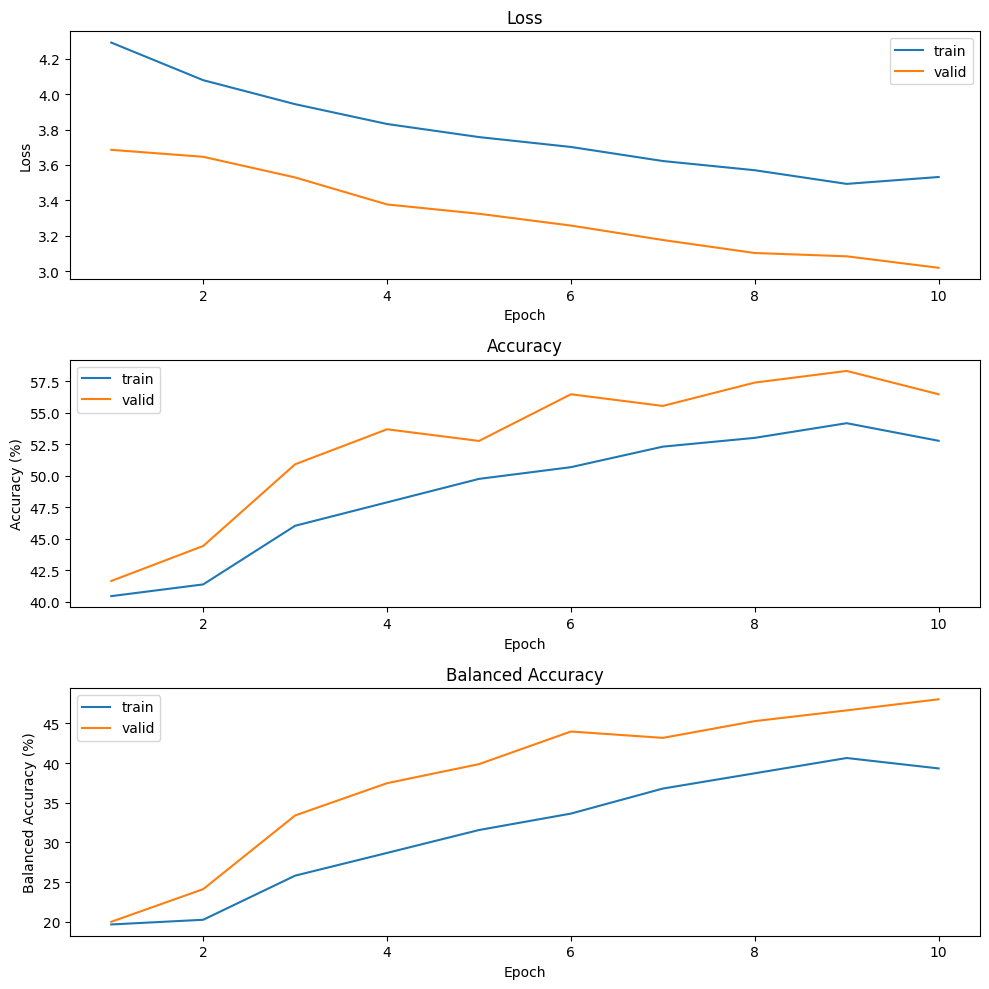

In [ ]:
plot_train_eval_result(
           train_loss_list, train_acc_list, train_balanced_acc_list, \
           valid_loss_list, valid_acc_list, valid_balanced_acc_list)


In [ ]:
valid_loss, valid_acc, valid_balanced_acc, y_pred, y_gt = evaluation(best_model_valid_acc, valid_dataloader, criteria, device)

print("valid_loss:", valid_loss, "valid_acc:", valid_acc, "valid_balanced_acc:", valid_balanced_acc)

path_list, labels = zip(*valid_set)
for pred, gt, label, path in zip(y_pred, y_gt, labels, path_list):
    # if pred != gt:
    # if gt != label:
    filename = path.name
    print(f"pred: {dict_id_to_label[pred]}, gt: {dict_id_to_label[gt]}, label: {dict_id_to_label[label]}, filename: {filename}")

  0%|          | 0/14 [00:00<?, ?it/s]

confusion_matrix_result:
[[31  8  0  6  0]
 [ 8 14  0  3  0]
 [ 0  5  2  2  0]
 [ 2  2  1 15  0]
 [ 4  3  0  1  1]]
get_category_accuracy:[0.68888889 0.56       0.22222222 0.75       0.11111111]
valid_loss: 3.0838995156464755 valid_acc: 0.5833333333333334 valid_balanced_acc: 0.46644444444444444
pred: EC, gt: MC, label: MC, filename: 46815.jpg
pred: CC, gt: HGSC, label: HGSC, filename: 39297.jpg
pred: HGSC, gt: HGSC, label: HGSC, filename: 18568.jpg
pred: HGSC, gt: HGSC, label: HGSC, filename: 39728.jpg
pred: EC, gt: HGSC, label: HGSC, filename: 35998.jpg
pred: HGSC, gt: CC, label: CC, filename: 38687.jpg
pred: HGSC, gt: HGSC, label: HGSC, filename: 35652.jpg
pred: HGSC, gt: HGSC, label: HGSC, filename: 52438.jpg
pred: HGSC, gt: EC, label: EC, filename: 23629.jpg
pred: EC, gt: EC, label: EC, filename: 53098.jpg
pred: HGSC, gt: HGSC, label: HGSC, filename: 18196.jpg
pred: MC, gt: MC, label: MC, filename: 56993.jpg
pred: HGSC, gt: HGSC, label: HGSC, filename: 6175.jpg
pred: EC, gt: EC, la

In [ ]:
print(f"pred: {dict_id_to_label[pred]}, gt: {dict_id_to_label[gt]}, label: {dict_id_to_label[label]}, filename: {filename}")
# put pred, gt, label, filename into a dataframe
pd_predict = pd.DataFrame({"image_id": [path.name.split(".")[0] for path in path_list], "label": y_pred, "gt": y_gt})
# display(pd_predict)
pd_predict.to_csv(Path(RESULT_DIR) / "pd_predict.csv", index=False)

pred: EC, gt: HGSC, label: HGSC, filename: 4211.jpg


: 

In [ ]:
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
# utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

# efficientnet.eval().to(device)


In [ ]:
# # Download an example image
# import urllib
# url, filename = ("https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "TCGA_CS_4944.png")
# try: urllib.URLopener().retrieve(url, filename)
# except: urllib.request.urlretrieve(url, filename)


In [ ]:
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True)


In [ ]:
# import numpy as np
# from PIL import Image
# from torchvision import transforms

# input_image = Image.open(filename)
# m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
# preprocess = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=m, std=s),
# ])
# input_tensor = preprocess(input_image)
# input_batch = input_tensor.unsqueeze(0)

# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model = model.to('cuda')

# with torch.no_grad():
#     output = model(input_batch)

# print(torch.round(output[0]))